## Calculate statistcs
1. Find valid tracks within Houston region
2. Calculate statistics including: radius, lifetime, start and end time, start and end status, cell location, maxrange_flag (touch the boudary), maxdbz, maxdbz height

In [1]:
%load_ext autoreload
%autoreload 2
import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from radar_util import radar_util
%config InlineBackend.figure_format='retina'

In [2]:
# Parameters
projectdir = '/rcfs/projects/windpower_wfip2uq/liuy351/Tracer'
radar_lat = 29.47194480896
radar_lon = -95.0788879394531
figdir = './radar_fig'
os.makedirs(figdir, exist_ok=True)

# Controlling variables
flag_mkdata=True
year1 = 2005
year2 = 2017

In [3]:
data = {}
# load tracks stats
if year2 is None:
    stats  = xr.open_dataset(f'{projectdir}/trackstats_concatenated/{year1}_valid.nc')
    stats2 = pd.read_csv(f'{projectdir}/trackstats_concatenated/{year1}.stats.csv')
else:
    stats  = xr.open_dataset(f'{projectdir}/trackstats_concatenated/{year1}-{year2}_valid.nc')
    stats2 = pd.read_csv(f'{projectdir}/trackstats_concatenated/{year1}-{year2}.stats.csv')
ntracks = stats.dims['tracks']

data['ntracks'] = ntracks
# print(stats)
# print(data)
data = radar_util.get_cell_statistics(data, stats)

ind = np.where((stats2['start_lon']<-90)&(stats2['start_lat']>20))[0]
stats2 = stats2.iloc[ind,:]

x, y, start, end, start_nonsplit_in  = radar_util.count_tracks_by_location(stats2)

### Split the tracks based on SOM types

In [5]:
def plot_on_map(x, y, data, **kwargs):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'  

    if (fig:=kwargs.get('fig')) is None:  
        fig = plt.figure(figsize=(8, 5))
    if (ax:=kwargs.get('ax')) is None:  ax = plt.axes()
    ax.set_axis_on()
    lon = -95.08; 
    lat = 29.47
    plot_map.set_map(
        ax,
        extent=[np.min(x),np.max(x),np.min(y), np.max(y)],
        gridlines_kw=dict(
            xticks=[-95.8,-95.4,-95.0,-94.6,-94.2],
            yticks=[28.6,29.,29.4,29.8,30.2],
            linestyle=":", alpha=0.3,
        ),
        gridlabels_kw=dict(
            xticks=[-95.8,-95.4,-95.0,-94.6,-94.2] if kwargs.get('drawxlabel', False) else [],
            yticks=[28.6,29.,29.4,29.8,30.2] if kwargs.get('drawylabel', False) else [],
        ),
        boundary_kw=dict(
            coastline_kw=dict(linewidth=1.2, alpha=0.8, color='k'),
        ),
    )

    cmap = kwargs.get('cmap', "WhiteBlueGreenYellowRed")
    clev = kwargs.get('clev', np.arange(0, 40, 1))
    cs, clev = plot_map.add_pcolormesh(
        ax, x, y, data,
        cmap=cmap,clev=clev,
    )
    if kwargs.get('draw_colorbar'):
        plot_map.add_colorbar(cs, ax, clev[::10])
        
    return cs, clev


## Plot frequency of cell initiation at each hour of the day for four seasons

swaping bmu....
swaping bmu....
swaping bmu....
swaping bmu....


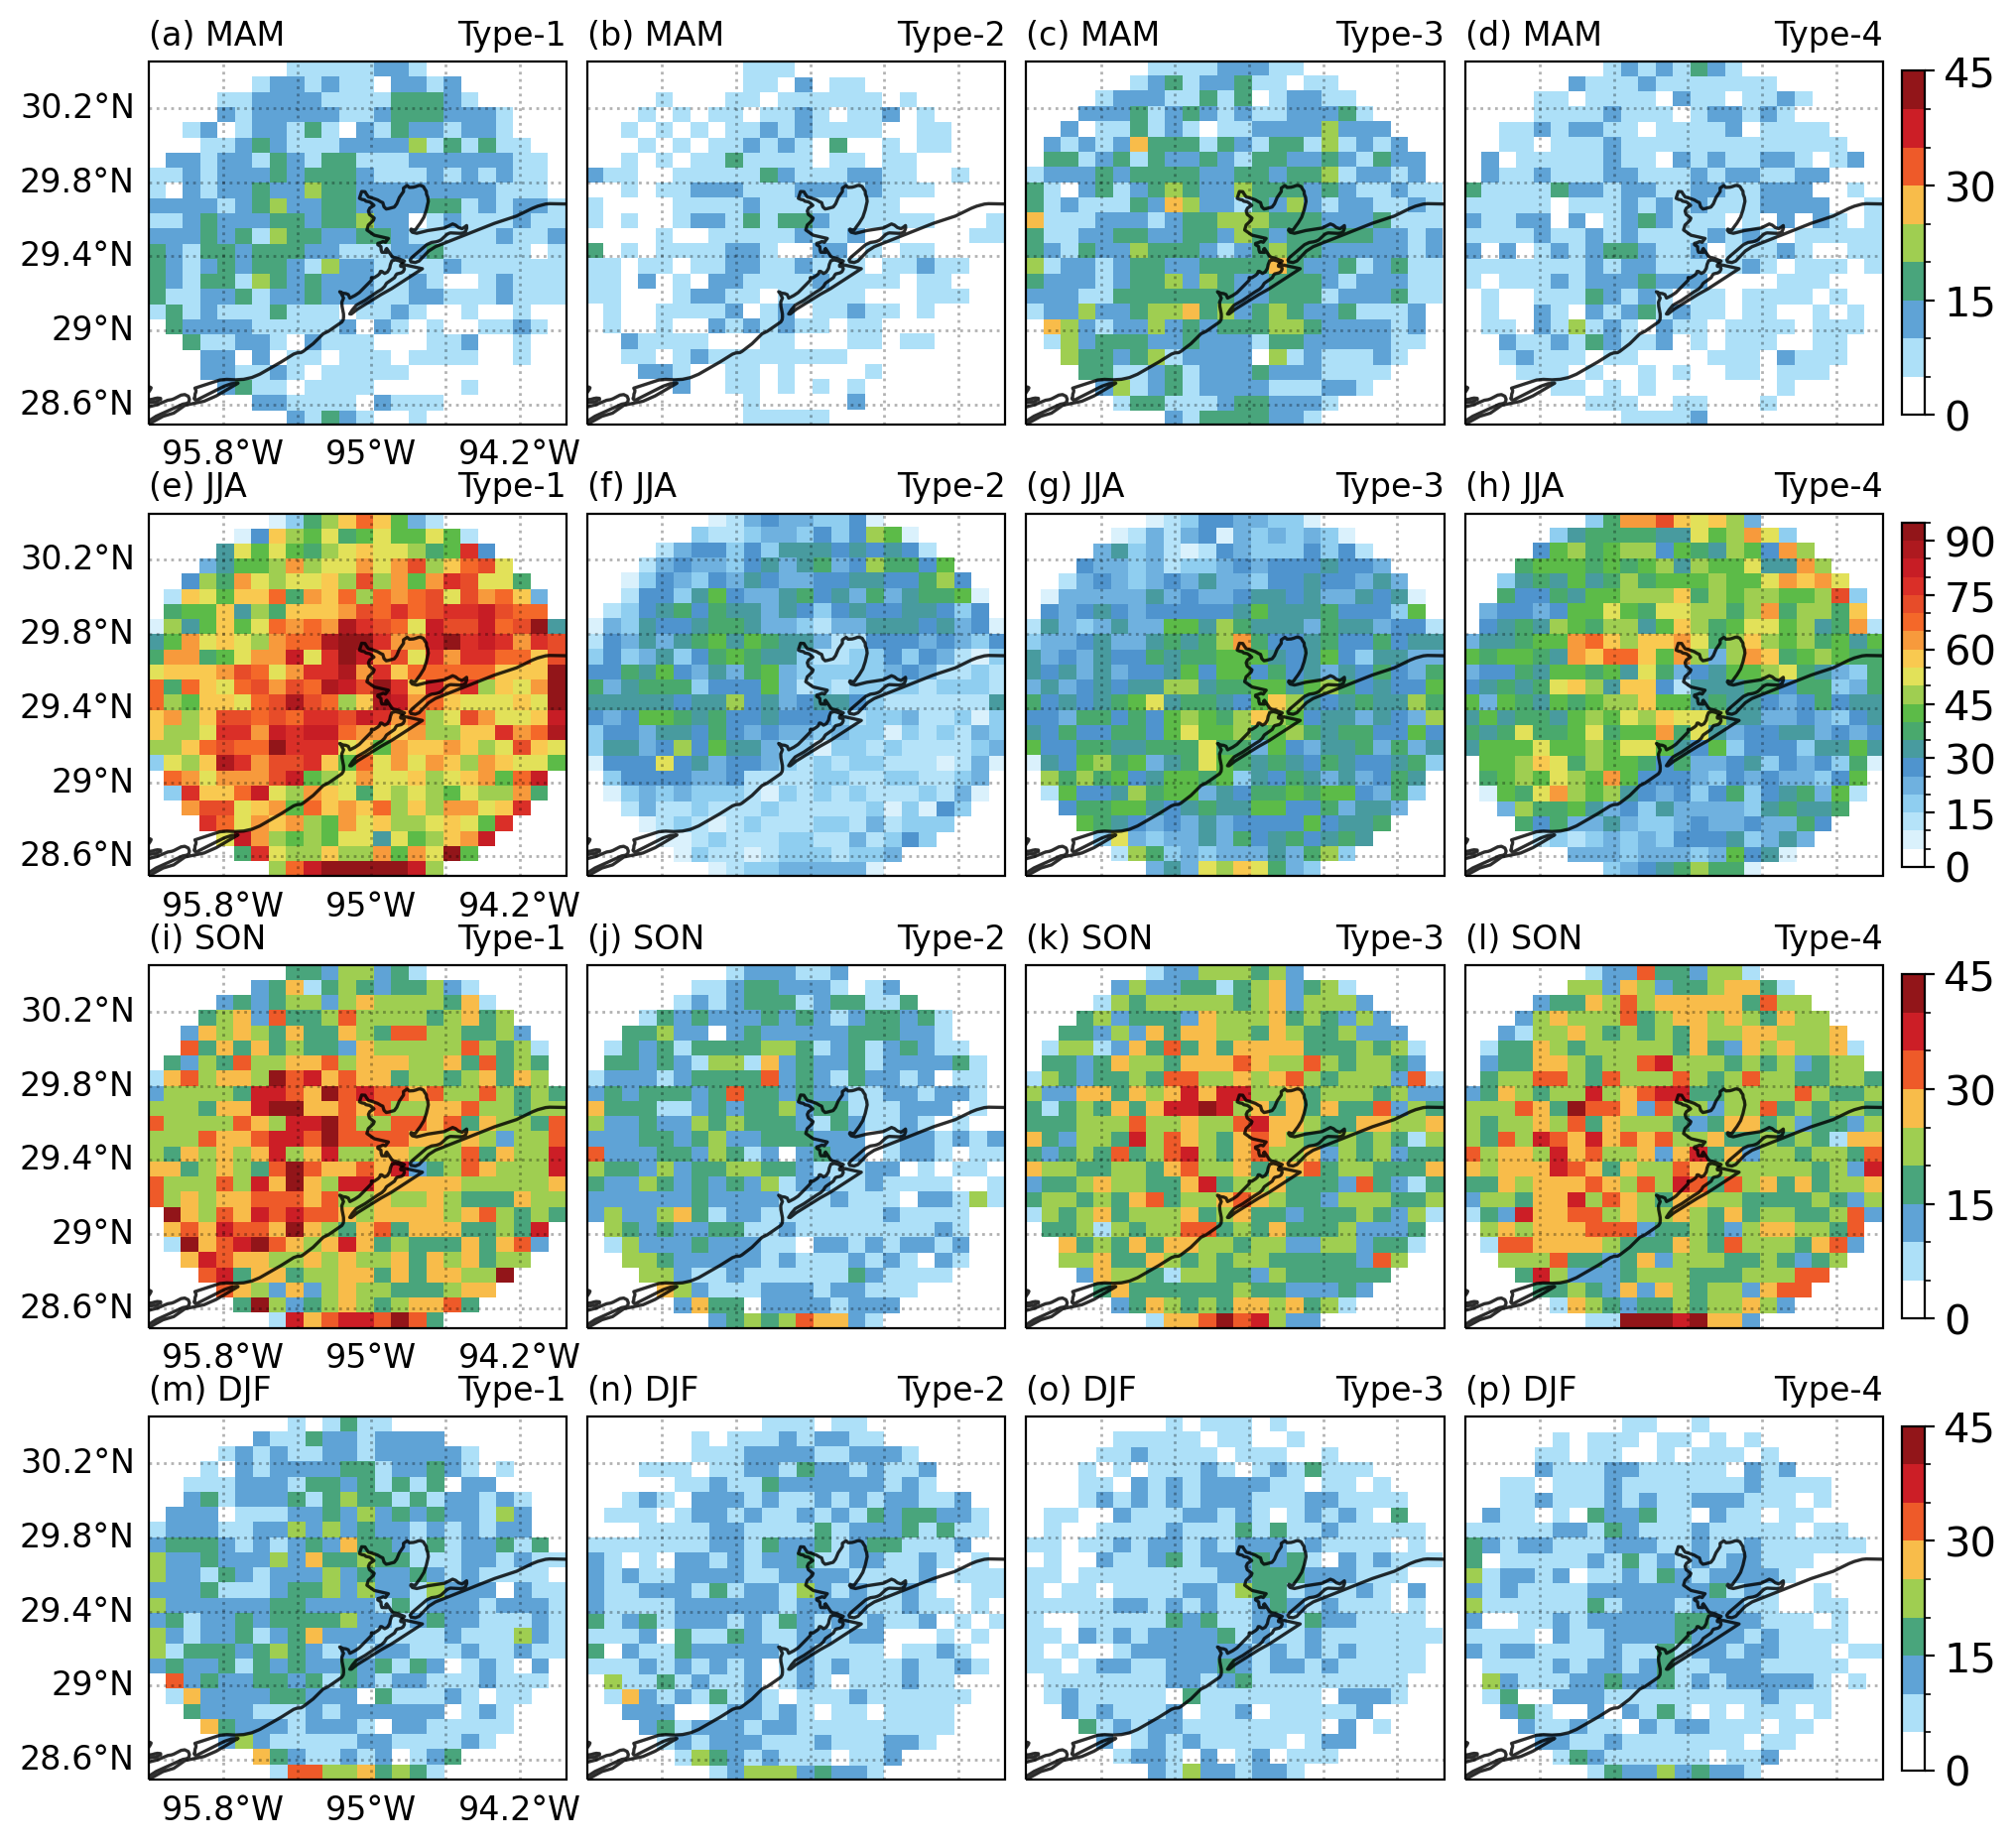

In [6]:
fig, axs = plt.subplots(
    4, 4, figsize=(10, 10), 
    sharex=True, sharey=True, 
    subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.05, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmnop')
for ax in axs: ax.set_axis_off()

cnt = 0
cmap = "WhiteBlueGreenYellowRed"
for i, season in enumerate(['MAM', 'JJA', 'SON', 'DJF']):
    if season=='JJA': 
        # clev = np.arange(0,25,1)
        clev = np.arange(0,100,5)
    else:
        clev = np.arange(0,50,5)
    track_cluster = radar_util.calc_cell_cluster_som(stats2, season=season)
    x, y = [], []
    color = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'k']
    for som in np.arange(4):
        ax = axs[i*4+som]
        _stats  = stats.sel(tracks=track_cluster[som])
        _stats2 = stats2.loc[stats2['tracks'].isin(track_cluster[som]),:]

        # Count tracks by diurnal timing
        x, y, start, end, start_nonsplit_in  = radar_util.count_tracks_by_location(_stats2)
        cs, clev = plot_on_map(
            x, y, start,
            fig=fig, ax=ax,
            cmap=cmap, clev=clev,
            title=season,
            drawxlabel=True if som==0 else False,
            drawylabel=True if som==0 else False,
            
        )
        ax.set_title(f'({abcd[cnt]}) {season}', loc='left', fontsize=12)
        ax.set_title(f'Type-{som+1}', loc='right', fontsize=12)
        cnt += 1

    plot_map.add_colorbar(
        cs, axs[i*4:i*4+4], clev[::3],
        orientation='vertical', 
        aspect=15, shrink=0.8,
        pad=0.01
    )


plt.show()

swaping bmu....
1.905892656556944
1.944313807684185
1.9082445528236427
1.9400127152102944
[40.63394265 14.61046546 20.595106   24.1604859 ]


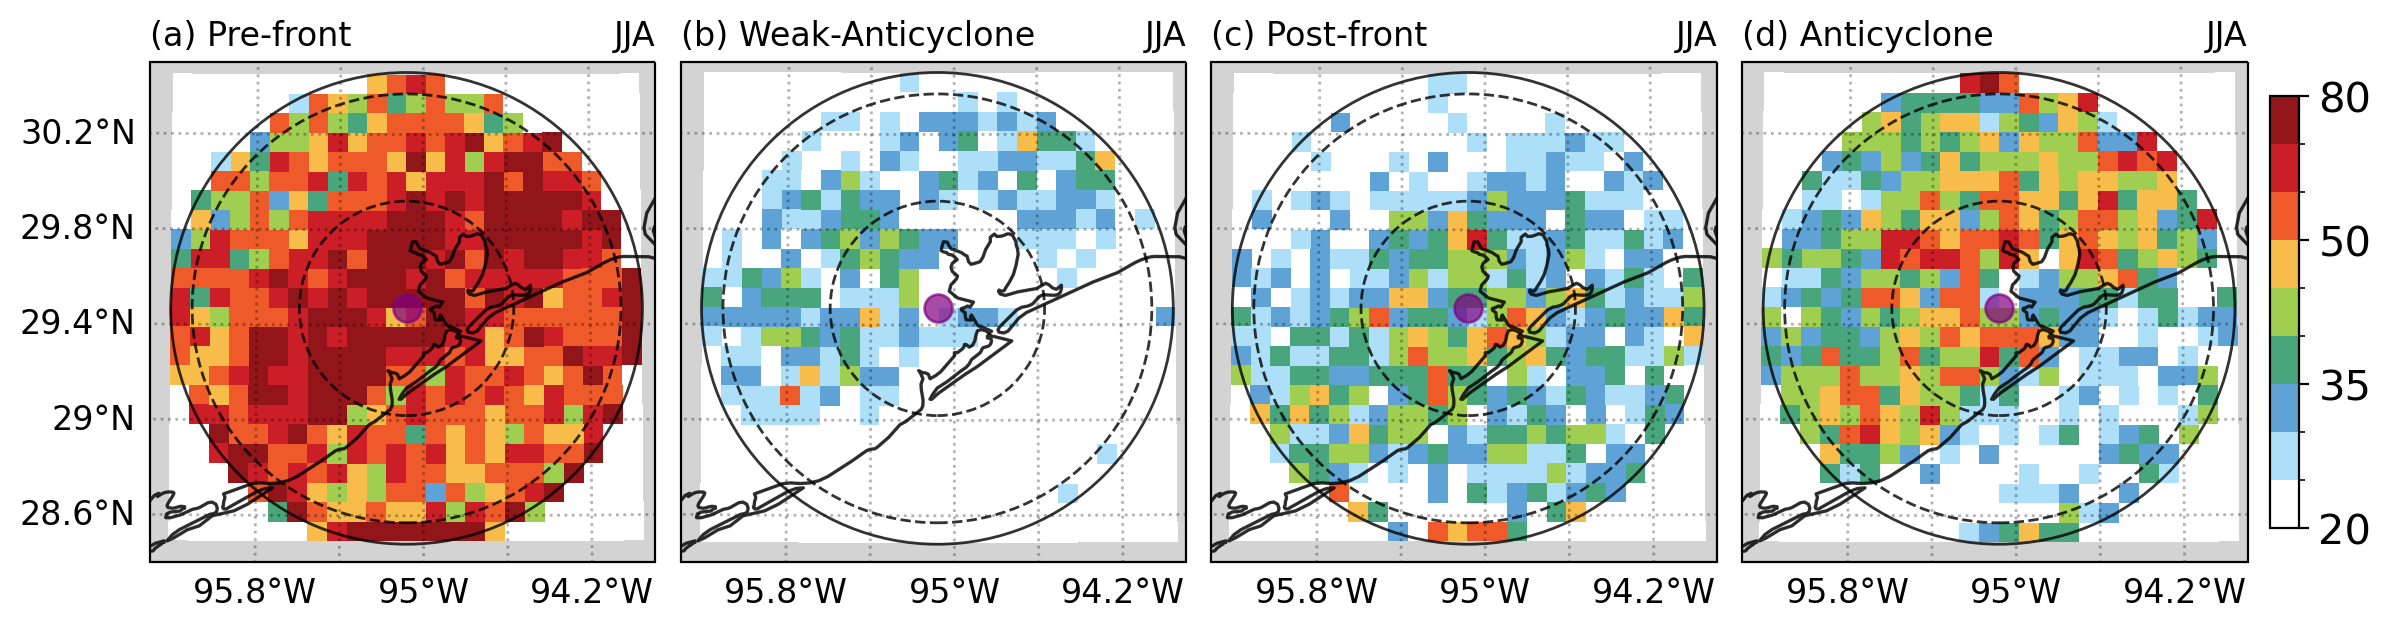

In [7]:
import matplotlib.patches as mpatches
def add_circle(ax, proj, r=100, ls='-'):
    lon = -95.08; 
    lat = 29.47

    def compute_radius(ortho, radius_degrees):
        phi1 = lat + radius_degrees if lat <= 0 else lat - radius_degrees
        _, y1 = ortho.transform_point(lon, phi1, ccrs.PlateCarree())
        return abs(y1)

    # Compute the required radius in projection native coordinates:
    r_ortho = compute_radius(proj, r)
    ax.add_patch(mpatches.Circle(xy=[lon, lat], radius=r_ortho, edgecolor='k', linestyle=ls, facecolor='none', alpha=0.8, transform=proj, zorder=30))

center_x = -95.08; center_y = 29.47    
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=center_x, central_latitude=center_y)

fig, axs = plt.subplots(
    1, 4, figsize=(12, 4), 
    sharex=True, sharey=True, 
    subplot_kw={'projection': proj})
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.05, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmnop')
for ax in axs: ax.set_axis_off()

cnt = 0
cmap = "WhiteBlueGreenYellowRed"
for i, season in enumerate(['JJA']):
    if season=='JJA': 
        clev = np.arange(0,100,5)
    else:
        clev = np.arange(0,50,5)
    clev = np.arange(-3, 50)
    clev = [20,25,30,35,40,45,50,60,70,80]
    track_cluster = radar_util.calc_cell_cluster_som(stats2, season=season)
    x, y = [], []
    color = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'k']
    string = ['Pre-front', 'Weak-Anticyclone', 'Post-front', 'Anticyclone']
    total = []
    for som in np.arange(4):
        ax = axs[i*4+som]
        _stats  = stats.sel(tracks=track_cluster[som])
        _stats2 = stats2.loc[stats2['tracks'].isin(track_cluster[som]),:]

        # Count tracks by diurnal timing
        x, y, start, end, start_nonsplit_in  = radar_util.count_tracks_by_location(_stats2)
        factor = np.cos(y[1:]/180*np.pi)
        xx, yy = np.meshgrid(x[1:], y[1:])
        dis = ((xx-center_x)*factor)**2 + (yy-center_y)**2
        print(dis.max())
        start =  np.where(dis<0.99, start, 0)
        total.append(start.sum())
        # start = start - start.mean()
        if som == 0: 
            mask = start
        else:
            start = np.where(mask>-10, start, -10)
        # x = x + 0.04
        # y = y + 0.04
        cs, clev = plot_on_map(
            x, y, start,
            fig=fig, ax=ax,
            cmap=cmap, clev=clev,
            title=season,
            drawxlabel=True,
            drawylabel=True if som==0 else False,
        )
        ax.set_title(f'({abcd[cnt]}) {string[som]}', loc='left', fontsize=12)
        ax.set_title(f'JJA', loc='right', fontsize=12)
        cnt += 1
        add_circle(ax, proj, 0.99, '-')
        add_circle(ax, proj, 0.90, '--')
        add_circle(ax, proj, 0.45, '--')
        ax.plot(center_x, center_y, marker='o', color='purple', markersize=10,
            alpha=0.7, transform=ccrs.Geodetic())
        ax.set_extent([-96.3, -93.9, 28.4, 30.5])

    plot_map.add_colorbar(
        cs, axs[i*4:i*4+4], clev[::3],
        orientation='vertical', 
        aspect=15, shrink=0.6,
        pad=0.01
    )
total = np.array(total)
total = total / total.sum() * 100.
print(total)
plt.show()


swaping bmu....
1.9169921064747846
1.9120982929885324
1.9052271817318127
1.9063915281628838
[30.98219104 14.97841338 25.86076632 28.17862925]


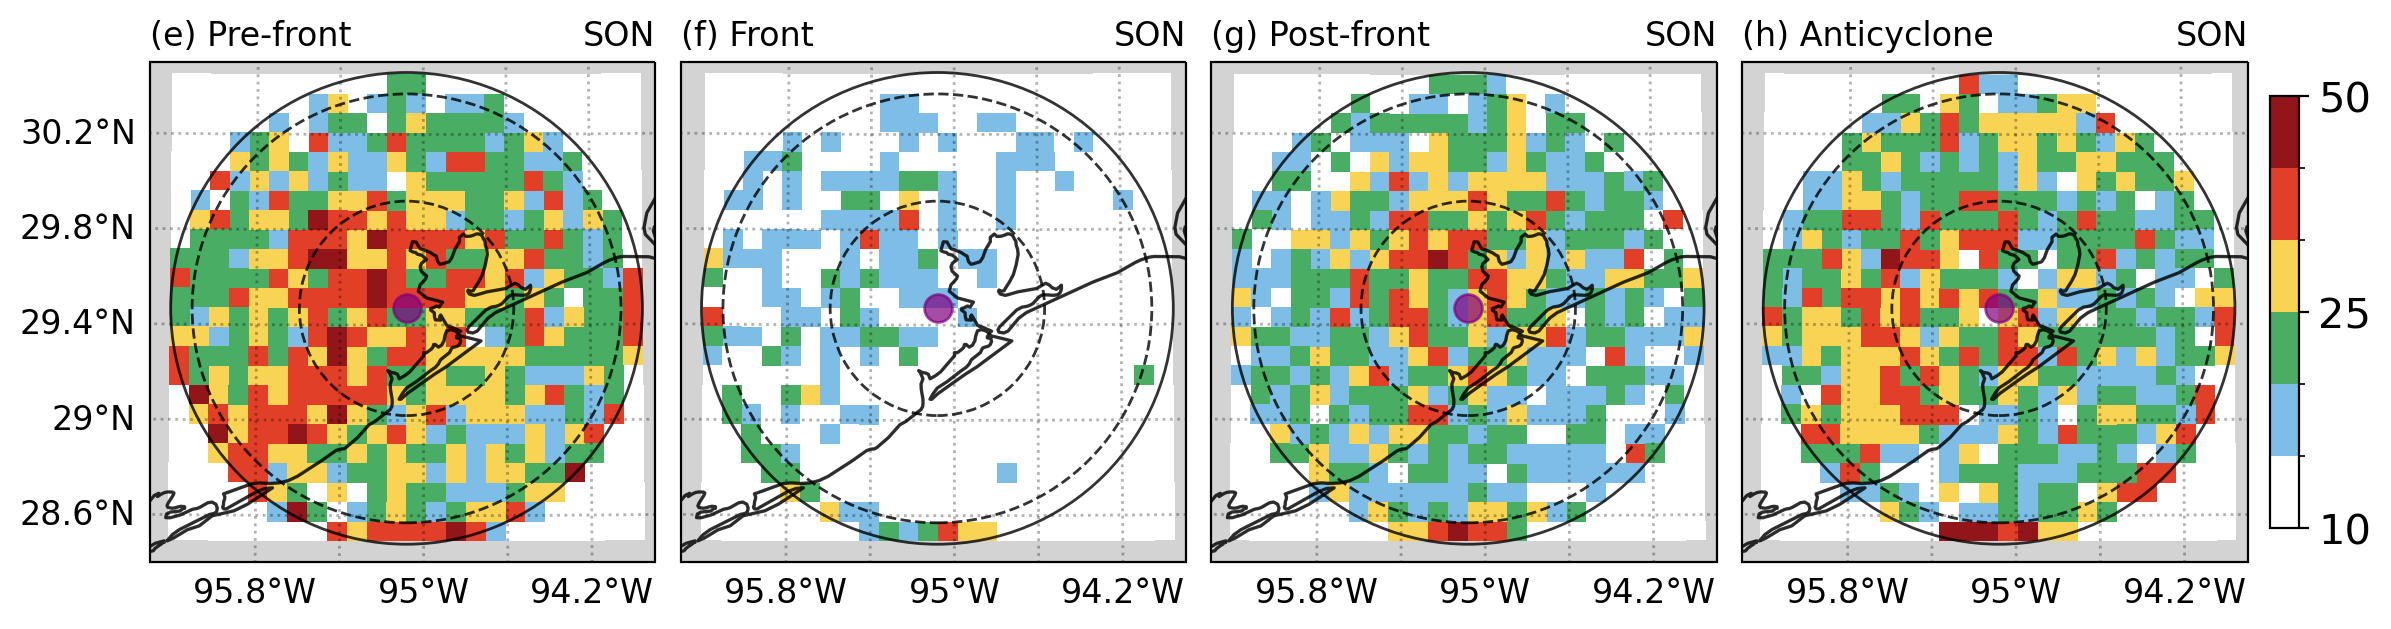

In [8]:
import matplotlib.patches as mpatches
def add_circle(ax, proj, r=100, ls='-'):
    lon = -95.08; 
    lat = 29.47

    def compute_radius(ortho, radius_degrees):
        phi1 = lat + radius_degrees if lat <= 0 else lat - radius_degrees
        _, y1 = ortho.transform_point(lon, phi1, ccrs.PlateCarree())
        return abs(y1)

    # Compute the required radius in projection native coordinates:
    r_ortho = compute_radius(proj, r)
    ax.add_patch(mpatches.Circle(xy=[lon, lat], radius=r_ortho, edgecolor='k', linestyle=ls, facecolor='none', alpha=0.8, transform=proj, zorder=30))

center_x = -95.08; center_y = 29.47    
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=center_x, central_latitude=center_y)

fig, axs = plt.subplots(
    1, 4, figsize=(12, 4), 
    sharex=True, sharey=True, 
    subplot_kw={'projection': proj})
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.05, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmnop')
for ax in axs: ax.set_axis_off()

cnt = 0
cmap = "WhiteBlueGreenYellowRed"
for i, season in enumerate(['SON']):
    if season=='SON': 
        clev = np.arange(0,100,5)
    else:
        clev = np.arange(0,50,5)
    clev = np.arange(-3, 50)
    # clev = [20,25,30,35,40,45,50,60,70,80]
    clev = [10,15,20,25,30,40,50]
    track_cluster = radar_util.calc_cell_cluster_som(stats2, season=season)
    x, y = [], []
    color = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'k']
    string = ['Pre-front', 'Front', 'Post-front', 'Anticyclone']
    total = []
    for som in np.arange(4):
        ax = axs[i*4+som]
        _stats  = stats.sel(tracks=track_cluster[som])
        _stats2 = stats2.loc[stats2['tracks'].isin(track_cluster[som]),:]

        # Count tracks by diurnal timing
        x, y, start, end, start_nonsplit_in  = radar_util.count_tracks_by_location(_stats2)
        factor = np.cos(y[1:]/180*np.pi)
        xx, yy = np.meshgrid(x[1:], y[1:])
        dis = ((xx-center_x)*factor)**2 + (yy-center_y)**2
        print(dis.max())
        start =  np.where(dis<0.99, start, 0)
        total.append(start.sum())
        # start = start - start.mean()
        if som == 0: 
            mask = start
        else:
            start = np.where(mask>-10, start, -10)
        # x = x + 0.04
        # y = y + 0.04
        cs, clev = plot_on_map(
            x, y, start,
            fig=fig, ax=ax,
            cmap=cmap, clev=clev,
            title=season,
            drawxlabel=True,
            drawylabel=True if som==0 else False,
        )
        ax.set_title(f'({abcd[cnt+4]}) {string[som]}', loc='left', fontsize=12)
        ax.set_title(f'SON', loc='right', fontsize=12)
        cnt += 1
        add_circle(ax, proj, 0.99, '-')
        add_circle(ax, proj, 0.90, '--')
        add_circle(ax, proj, 0.45, '--')
        ax.plot(center_x, center_y, marker='o', color='purple', markersize=10,
            alpha=0.7, transform=ccrs.Geodetic())
        ax.set_extent([-96.3, -93.9, 28.4, 30.5])

    plot_map.add_colorbar(
        cs, axs[i*4:i*4+4], clev[::3],
        orientation='vertical', 
        aspect=15, shrink=0.6,
        pad=0.01
    )
total = np.array(total)
total = total / total.sum() * 100.
print(total)
plt.show()


swaping bmu....
1.905892656556944
1.944313807684185
1.9082445528236427
1.9400127152102944
swaping bmu....
1.9169921064747846
1.9120982929885324
1.9052271817318127
1.9063915281628838
[30.98219104 14.97841338 25.86076632 28.17862925]


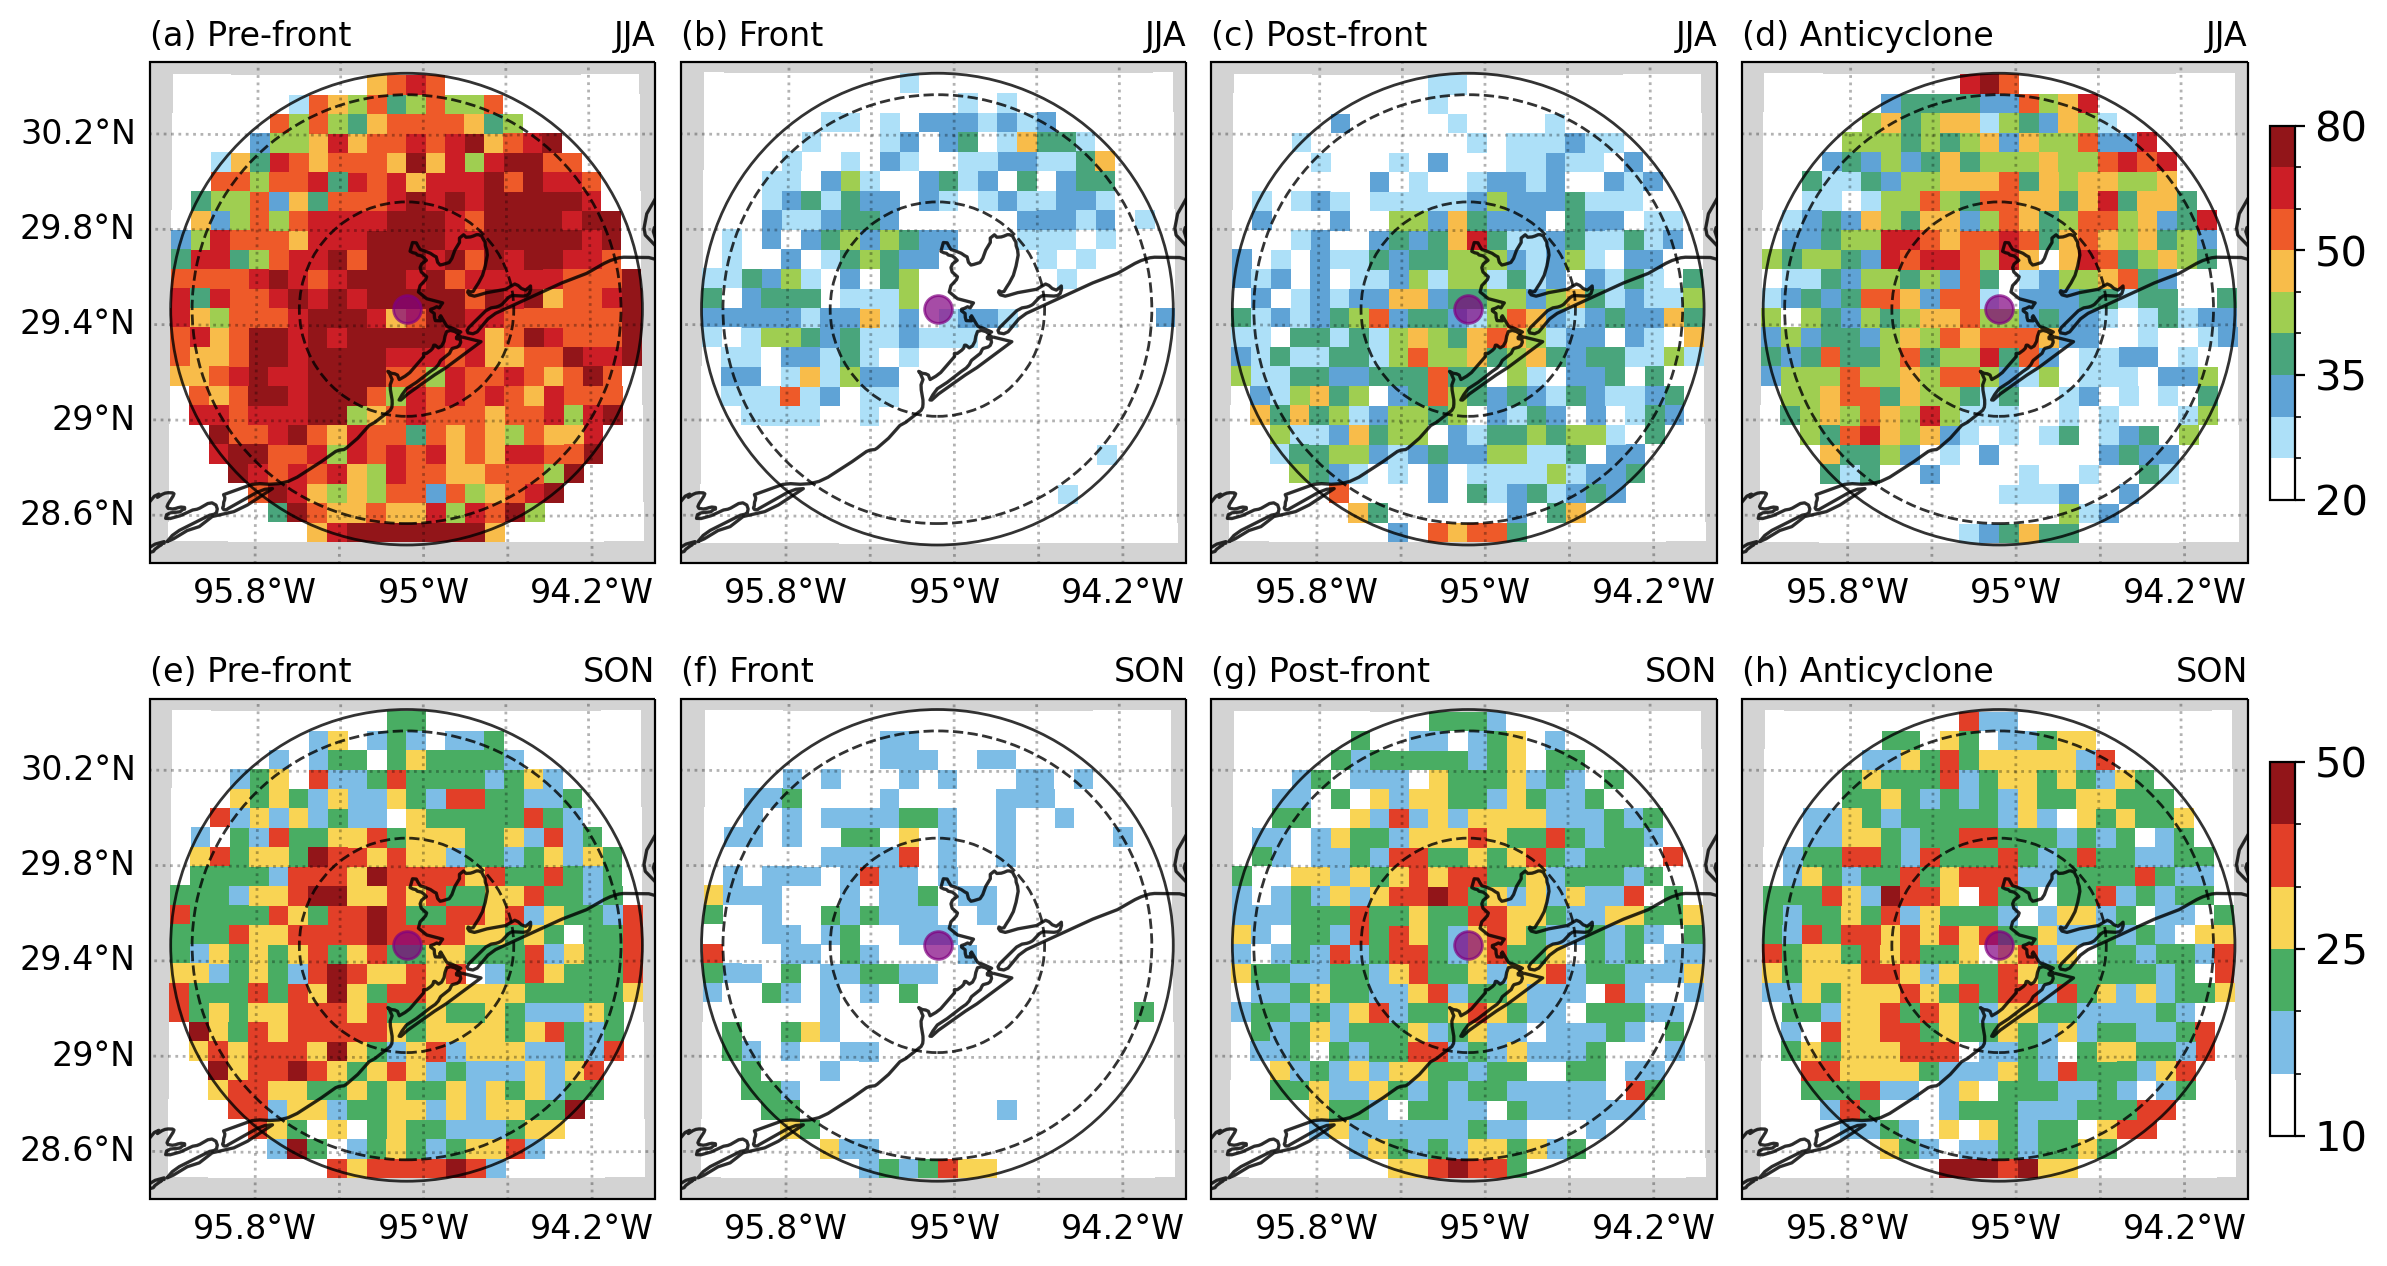

In [12]:
import matplotlib.patches as mpatches
def add_circle(ax, proj, r=100, ls='-'):
    lon = -95.08; 
    lat = 29.47

    def compute_radius(ortho, radius_degrees):
        phi1 = lat + radius_degrees if lat <= 0 else lat - radius_degrees
        _, y1 = ortho.transform_point(lon, phi1, ccrs.PlateCarree())
        return abs(y1)

    # Compute the required radius in projection native coordinates:
    r_ortho = compute_radius(proj, r)
    ax.add_patch(mpatches.Circle(xy=[lon, lat], radius=r_ortho, edgecolor='k', linestyle=ls, facecolor='none', alpha=0.8, transform=proj, zorder=30))

center_x = -95.08; center_y = 29.47    
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=center_x, central_latitude=center_y)

fig, axs = plt.subplots(
    2, 4, figsize=(12, 7), 
    sharex=True, sharey=True, 
    subplot_kw={'projection': proj})
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.02, wspace=0.05)
axs = axs.ravel()
abcd = list('abcdefghijklmnop')
for ax in axs: ax.set_axis_off()

cnt = 0
cmap = "WhiteBlueGreenYellowRed"
for i, season in enumerate(['JJA','SON']):
    if season=='SON': 
        clev = [10,15,20,25,30,40,50]
    else:
        clev = [20,25,30,35,40,45,50,60,70,80]

    track_cluster = radar_util.calc_cell_cluster_som(stats2, season=season)
    x, y = [], []
    color = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'k']
    string = ['Pre-front', 'Front', 'Post-front', 'Anticyclone']
    total = []
    for som in np.arange(4):
        ax = axs[i*4+som]
        _stats  = stats.sel(tracks=track_cluster[som])
        _stats2 = stats2.loc[stats2['tracks'].isin(track_cluster[som]),:]

        # Count tracks by diurnal timing
        x, y, start, end, start_nonsplit_in  = radar_util.count_tracks_by_location(_stats2)
        factor = np.cos(y[1:]/180*np.pi)
        xx, yy = np.meshgrid(x[1:], y[1:])
        dis = ((xx-center_x)*factor)**2 + (yy-center_y)**2
        print(dis.max())
        start =  np.where(dis<0.99, start, 0)
        total.append(start.sum())
        # start = start - start.mean()
        if som == 0: 
            mask = start
        else:
            start = np.where(mask>-10, start, -10)
        # x = x + 0.04
        # y = y + 0.04
        cs, clev = plot_on_map(
            x, y, start,
            fig=fig, ax=ax,
            cmap=cmap, clev=clev,
            title=season,
            drawxlabel=True,
            drawylabel=True if som==0 else False,
        )
        ax.set_title(f'({abcd[cnt]}) {string[som]}', loc='left', fontsize=12)
        ax.set_title(f'{season}', loc='right', fontsize=12)
        cnt += 1
        add_circle(ax, proj, 0.99, '-')
        add_circle(ax, proj, 0.90, '--')
        add_circle(ax, proj, 0.45, '--')
        ax.plot(center_x, center_y, marker='o', color='purple', markersize=10,
            alpha=0.7, transform=ccrs.Geodetic())
        ax.set_extent([-96.3, -93.9, 28.4, 30.5])

    plot_map.add_colorbar(
        cs, axs[i*4:i*4+4], clev[::3],
        orientation='vertical', 
        aspect=15, shrink=0.6,
        pad=0.01
    )
total = np.array(total)
total = total / total.sum() * 100.
# fig.savefig('paper/Figure11.pdf', bbox_inches='tight')
fig.savefig('paper/Figure11.png', format='png', bbox_inches='tight', dpi=300)
print(total)
